# MLP Residual Connections: влияние residual connections на обучение глубоких MLP

Цель: изучить влияние различных типов residual connections на обучение глубоких MLP сетей.

Данные: Wine Quality (мультиклассовая классификация) - переиспользуем препроцессинг из предыдущего семинара.

Структура:
1. Абстрактные базовые классы для MLP блока и DeepMLP
2. Plain MLP блок без residual
3. MLP блок с residual add
4. MLP блок с residual concat
5. MLP блок с residual scaling (α/γ)
6. Эксперименты с разными глубинами (2, 6, 12, 18, 24)

Метрики: Accuracy и F1 (macro); кривые train/val loss


In [15]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchmetrics.classification import (
    Accuracy, F1Score
)
import sys
sys.path.append('../../lesson3/seminar')
from wine_quality_data import WineQualityDataModule
from lightning_module import BaseLightningModule
from utils import set_seed
from pytorch_lightning import Trainer

sns.set_style("whitegrid")
set_seed(42)


## 1. Абстрактные базовые классы

Создаем абстрактные базовые классы для MLP блока и глубокой MLP сети, от которых будут наследоваться конкретные реализации.


In [16]:
from abc import ABC, abstractmethod

class BaseMLPBlock(nn.Module, ABC):
    """
    Абстрактный базовый класс для MLP блока.
    
    Args:
        dim: размерность входа
        hidden_dim: размерность скрытого слоя и выхода (если None, то равен dim)
        activation: функция активации ('relu', 'gelu', 'swish')
        dropout: вероятность dropout
    """
    def __init__(
        self,
        dim,
        hidden_dim=None,
        activation='relu',
        dropout=0.0
    ):
        super().__init__()
        
        self.dim = dim
        self.hidden_dim = hidden_dim if hidden_dim is not None else dim
        
        # Линейные слои: dim -> hidden_dim -> hidden_dim
        self.linear1 = nn.Linear(self.dim, self.hidden_dim)
        self.linear2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        # Активация
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'swish':
            self.activation = nn.SiLU()
        else:
            self.activation = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
    
    @abstractmethod
    def forward(self, x):
        """
        Forward pass через блок.
        Выход всегда имеет размерность hidden_dim.
        """
        pass


class BaseDeepMLP(nn.Module, ABC):
    """
    Абстрактный базовый класс для глубокой MLP сети.
    
    Args:
        input_dim: размерность входа
        output_dim: размерность выхода
        hidden_dim: размерность скрытых слоев
        num_blocks: количество блоков
        block_kwargs: дополнительные аргументы для блока
    """
    def __init__(
        self,
        input_dim,
        output_dim,
        hidden_dim=128,
        num_blocks=4,
        block_kwargs=None
    ):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_blocks = num_blocks
        
        # Входной проекционный слой
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # Блоки (будут созданы в дочерних классах)
        self.blocks = None
        
        # Выходной слой
        self.output_proj = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.input_proj(x)
        
        if self.blocks is not None:
            for block in self.blocks:
                x = block(x)
        
        x = self.output_proj(x)
        return x


## 2. Plain MLP блок без residual

Базовый блок без residual connections для сравнения.


In [17]:
class PlainMLPBlock(BaseMLPBlock):
    """
    Простой MLP блок без residual connections.
    """
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.linear2(x)
        x = self.activation(x)
        return x


class PlainDeepMLP(BaseDeepMLP):
    """
    Глубокая MLP сеть из PlainMLPBlock без residual connections.
    """
    def __init__(
        self,
        input_dim,
        output_dim,
        hidden_dim=128,
        num_blocks=4,
        block_kwargs=None
    ):
        super().__init__(input_dim, output_dim, hidden_dim, num_blocks, block_kwargs)
        
        block_kwargs = block_kwargs or {}
        self.blocks = nn.ModuleList([
            PlainMLPBlock(dim=hidden_dim, hidden_dim=hidden_dim, **block_kwargs)
            for _ in range(num_blocks)
        ])


## 3. MLP блок с residual add

Блок с residual connection через сложение.


In [18]:
class ResidualAddMLPBlock(BaseMLPBlock):
    """
    MLP блок с residual connection через сложение.
    
    Args:
        dim: размерность входа и выхода
        hidden_dim: размерность скрытого слоя (если None, то равен dim)
        activation: функция активации
        dropout: вероятность dropout
        residual_alpha: коэффициент масштабирования residual (α)
    """
    def __init__(
        self,
        dim,
        hidden_dim=None,
        activation='relu',
        dropout=0.0,
        residual_alpha=1.0
    ):
        super().__init__(dim, hidden_dim, activation, dropout)
        
        self.residual_alpha = residual_alpha
        
        # Проекционный shortcut нужен, если размерности входа и выхода не совпадают
        if self.dim != self.hidden_dim:
            self.projection = nn.Linear(self.dim, self.hidden_dim)
        else:
            self.projection = None
    
    def forward(self, x):
        identity = x
        
        x = self.linear1(x)
        x = self.activation(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.linear2(x)
        x = self.activation(x)
        
        # Residual connection через сложение
        if self.projection is not None:
            identity = self.projection(identity)
        
        x = self.residual_alpha * x + identity # x + a * F(x)
        
        return x


class ResidualAddDeepMLP(BaseDeepMLP):
    """
    Глубокая MLP сеть из ResidualAddMLPBlock.
    """
    def __init__(
        self,
        input_dim,
        output_dim,
        hidden_dim=128,
        num_blocks=4,
        block_kwargs=None
    ):
        super().__init__(input_dim, output_dim, hidden_dim, num_blocks, block_kwargs)
        
        block_kwargs = block_kwargs or {}
        self.blocks = nn.ModuleList([
            ResidualAddMLPBlock(dim=hidden_dim, hidden_dim=hidden_dim, **block_kwargs)
            for _ in range(num_blocks)
        ])


## 4. MLP блок с residual concat

Блок с residual connection через конкатенацию.


In [19]:
class ResidualConcatMLPBlock(BaseMLPBlock):
    """
    MLP блок с residual connection через конкатенацию.
    
    Args:
        dim: размерность входа
        hidden_dim: размерность скрытого слоя (если None, то равен dim)
        activation: функция активации
        dropout: вероятность dropout
    """
    def __init__(
        self,
        dim,
        hidden_dim=None,
        activation='relu',
        dropout=0.0
    ):
        super().__init__(dim, hidden_dim, activation, dropout)
        
        # При конкатенации выходная размерность увеличивается
        # Поэтому нужен дополнительный линейный слой для уменьшения размерности
        # dim -> hidden_dim -> hidden_dim, затем concat с dim -> hidden_dim + dim -> hidden_dim
        self.linear1 = nn.Linear(self.dim, self.hidden_dim)
        self.linear2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.linear_out = nn.Linear(self.hidden_dim + self.dim, self.hidden_dim)
    
    def forward(self, x):
        identity = x
        
        x = self.linear1(x)
        x = self.activation(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.linear2(x)
        x = self.activation(x)
        
        # Residual connection через конкатенацию
        x = torch.cat([x, identity], dim=1)
        x = self.linear_out(x)
        
        return x


class ResidualConcatDeepMLP(BaseDeepMLP):
    """
    Глубокая MLP сеть из ResidualConcatMLPBlock.
    """
    def __init__(
        self,
        input_dim,
        output_dim,
        hidden_dim=128,
        num_blocks=4,
        block_kwargs=None
    ):
        super().__init__(input_dim, output_dim, hidden_dim, num_blocks, block_kwargs)
        
        block_kwargs = block_kwargs or {}
        self.blocks = nn.ModuleList([
            ResidualConcatMLPBlock(dim=hidden_dim, hidden_dim=hidden_dim, **block_kwargs)
            for _ in range(num_blocks)
        ])


## 5. MLP блок с residual scaling (α/γ)

Блок с residual connection и масштабированием (α - коэффициент residual, γ - LayerScale).


In [20]:
class ResidualScalingMLPBlock(BaseMLPBlock):
    """
    MLP блок с residual connection и масштабированием.
    
    Args:
        dim: размерность входа и выхода
        hidden_dim: размерность скрытого слоя (если None, то равен dim)
        activation: функция активации
        dropout: вероятность dropout
        residual_alpha: коэффициент масштабирования residual (α)
        use_layer_scale: использовать ли LayerScale (γ)
        layer_scale_init: начальное значение для LayerScale
    """
    def __init__(
        self,
        dim,
        hidden_dim=None,
        activation='relu',
        dropout=0.0,
        residual_alpha=1.0,
        use_layer_scale=False,
        layer_scale_init=1e-6
    ):
        super().__init__(dim, hidden_dim, activation, dropout)
        
        self.residual_alpha = residual_alpha
        self.use_layer_scale = use_layer_scale
        
        # Проекционный shortcut нужен, если размерности входа и выхода не совпадают
        if self.dim != self.hidden_dim:
            self.projection = nn.Linear(self.dim, self.hidden_dim)
        else:
            self.projection = None
        
        # LayerScale (γ)
        if use_layer_scale:
            self.layer_scale = nn.Parameter(torch.ones(self.hidden_dim) * layer_scale_init)
        else:
            self.register_parameter('layer_scale', None)
    
    def forward(self, x):
        identity = x
        
        x = self.linear1(x)
        x = self.activation(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.linear2(x)
        x = self.activation(x)
        
        # Residual connection с масштабированием
        if self.projection is not None:
            identity = self.projection(identity)

        x = self.residual_alpha * x
        
        # LayerScale (γ)
        if self.layer_scale is not None:
            x = x * self.layer_scale

        x = x + identity # x + a * L * F(x)
        return x


class ResidualScalingDeepMLP(BaseDeepMLP):
    """
    Глубокая MLP сеть из ResidualScalingMLPBlock.
    """
    def __init__(
        self,
        input_dim,
        output_dim,
        hidden_dim=128,
        num_blocks=4,
        block_kwargs=None
    ):
        super().__init__(input_dim, output_dim, hidden_dim, num_blocks, block_kwargs)
        
        block_kwargs = block_kwargs or {}
        self.blocks = nn.ModuleList([
            ResidualScalingMLPBlock(dim=hidden_dim, hidden_dim=hidden_dim, **block_kwargs)
            for _ in range(num_blocks)
        ])


## 6. Подготовка данных


In [21]:
data_module = WineQualityDataModule(batch_size=64, val_split=0.2, random_state=42)
data_module.prepare_data()
data_module.setup()

print(f"Input dimension: {data_module.input_dim}")
print(f"Number of classes: {data_module.n_classes}")
print(f"Train samples: {len(data_module.train_dataset)}")
print(f"Val samples: {len(data_module.val_dataset)}")


Input dimension: 11
Number of classes: 6
Train samples: 1279
Val samples: 320


## 7. Функция обучения


In [22]:
def train_model(model, name, max_epochs=25):
    """Обучает модель и возвращает историю метрик."""
    set_seed(42)
    
    loss_fn = nn.CrossEntropyLoss()
    
    lightning_module = BaseLightningModule(
        model=model,
        loss_fn=loss_fn,
        optimizer_type='adam',
        learning_rate=1e-3,
        task_type='multiclass'
    )
    
    trainer = Trainer(
        max_epochs=max_epochs,
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=False
    )
    
    print(f"\n=== Обучение {name} ===")
    trainer.fit(lightning_module, data_module)
    
    # Собираем метрики
    history = {
        'train_loss': lightning_module.train_losses,
        'val_loss': lightning_module.val_losses,
        'name': name
    }
    
    # Вычисляем финальные метрики
    lightning_module.eval()
    model.eval()
    
    y_true_all = []
    y_pred_all = []
    
    with torch.no_grad():
        for batch in data_module.val_dataloader():
            x, y = batch
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            y_true_all.append(y.numpy())
            y_pred_all.append(preds.numpy())
    
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    
    y_true_tensor = torch.LongTensor(y_true)
    y_pred_tensor = torch.LongTensor(y_pred)
    
    accuracy_metric = Accuracy(task='multiclass', num_classes=data_module.n_classes)
    f1_metric = F1Score(task='multiclass', num_classes=data_module.n_classes, average='macro')
    
    accuracy = accuracy_metric(y_pred_tensor, y_true_tensor).item()
    f1 = f1_metric(y_pred_tensor, y_true_tensor).item()
    
    history['final_accuracy'] = accuracy
    history['final_f1'] = f1
    
    print(f"Accuracy: {accuracy:.4f}, F1 (macro): {f1:.4f}")
    
    return history


def average_train_loss_by_epochs(train_losses, num_epochs):
    """Усредняет train_loss по эпохам."""
    if len(train_losses) == num_epochs:
        return train_losses
    
    # Вычисляем количество шагов на эпоху
    steps_per_epoch = len(train_losses) // num_epochs
    if steps_per_epoch == 0:
        steps_per_epoch = 1
    
    # Усредняем по эпохам
    averaged = []
    for epoch in range(num_epochs):
        start_idx = epoch * steps_per_epoch
        end_idx = (epoch + 1) * steps_per_epoch
        if end_idx > len(train_losses):
            end_idx = len(train_losses)
        if start_idx < len(train_losses):
            epoch_losses = train_losses[start_idx:end_idx]
            averaged.append(np.mean(epoch_losses))
    
    return averaged


## 8. Эксперимент 1: Plain vs Residual Add

Сравним plain MLP без residual connections с MLP с residual add.


In [23]:
depths = [2, 6, 18, 24]
hidden_dim = 128
results_plain_vs_add = {}

# Plain MLP
for num_blocks in depths:
    model = PlainDeepMLP(
        input_dim=data_module.input_dim,
        output_dim=data_module.n_classes,
        hidden_dim=hidden_dim,
        num_blocks=num_blocks,
        block_kwargs={'dropout': 0.1}
    )
    
    name = f"Plain (depth={num_blocks})"
    history = train_model(model, name, max_epochs=25)
    results_plain_vs_add[name] = history

# Residual Add MLP
for num_blocks in depths:
    model = ResidualAddDeepMLP(
        input_dim=data_module.input_dim,
        output_dim=data_module.n_classes,
        hidden_dim=hidden_dim,
        num_blocks=num_blocks,
        block_kwargs={'dropout': 0.1, 'residual_alpha': 1.0}
    )
    
    name = f"Residual Add (depth={num_blocks})"
    history = train_model(model, name, max_epochs=25)
    results_plain_vs_add[name] = history


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Plain (depth=2) ===
Epoch 0: accuracy=0.0234, f1_macro=0.0253
Epoch 0: accuracy=0.3549, f1_macro=0.1470
Epoch 1: accuracy=0.4362, f1_macro=0.1804
Epoch 2: accuracy=0.4761, f1_macro=0.1927
Epoch 3: accuracy=0.5050, f1_macro=0.2089
Epoch 4: accuracy=0.5284, f1_macro=0.2348
Epoch 5: accuracy=0.5391, f1_macro=0.2363
Epoch 6: accuracy=0.5494, f1_macro=0.2515
Epoch 7: accuracy=0.5573, f1_macro=0.2582
Epoch 8: accuracy=0.5635, f1_macro=0.2641
Epoch 9: accuracy=0.5676, f1_macro=0.2666
Epoch 10: accuracy=0.5677, f1_macro=0.2647
Epoch 11: accuracy=0.5723, f1_macro=0.2679
Epoch 12: accuracy=0.5756, f1_macro=0.2702
Epoch 13: accuracy=0.5786, f1_macro=0.2736
Epoch 14: accuracy=0.5797, f1_macro=0.2753
Epoch 15: accuracy=0.5819, f1_macro=0.2768
Epoch 16: accuracy=0.5846, f1_macro=0.2781
Epoch 17: accuracy=0.5859, f1_macro=0.2788
Epoch 18: accuracy=0.5878, f1_macro=0.2808
Epoch 19: accuracy=0.5888, f1_macro=0.2827
Epoch 20: accuracy=0.5879, f1_macro=0.2825
Epoch 21: accuracy=0.5878, f1_m

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6250, F1 (macro): 0.2985

=== Обучение Plain (depth=6) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3542, f1_macro=0.0945
Epoch 2: accuracy=0.3750, f1_macro=0.0961
Epoch 3: accuracy=0.4112, f1_macro=0.1293
Epoch 4: accuracy=0.4323, f1_macro=0.1444
Epoch 5: accuracy=0.4517, f1_macro=0.1571
Epoch 6: accuracy=0.4666, f1_macro=0.1647
Epoch 7: accuracy=0.4795, f1_macro=0.1712
Epoch 8: accuracy=0.4904, f1_macro=0.1768
Epoch 9: accuracy=0.4976, f1_macro=0.1797
Epoch 10: accuracy=0.5030, f1_macro=0.1813
Epoch 11: accuracy=0.5098, f1_macro=0.1847
Epoch 12: accuracy=0.5166, f1_macro=0.1872
Epoch 13: accuracy=0.5221, f1_macro=0.1896
Epoch 14: accuracy=0.5256, f1_macro=0.2014
Epoch 15: accuracy=0.5292, f1_macro=0.2027
Epoch 16: accuracy=0.5329, f1_macro=0.2042
Epoch 17: accuracy=0.5384, f1_macro=0.2156
Epoch 18: accuracy=0.5427, f1_macro=0.2248
Epoch 19: accuracy=0.5463, f1_macro=0.2299
Epoch 20: accuracy=0.5494, f1_macro=0

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Epoch 23: accuracy=0.5610, f1_macro=0.2523
Epoch 24: accuracy=0.5646, f1_macro=0.2565
Accuracy: 0.6531, F1 (macro): 0.3328


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Plain (depth=18) ===
Epoch 0: accuracy=0.0469, f1_macro=0.0179
Epoch 0: accuracy=0.2991, f1_macro=0.0986
Epoch 1: accuracy=0.3411, f1_macro=0.1026
Epoch 2: accuracy=0.3658, f1_macro=0.1496
Epoch 3: accuracy=0.3793, f1_macro=0.1556
Epoch 4: accuracy=0.3877, f1_macro=0.1551
Epoch 5: accuracy=0.3936, f1_macro=0.1529
Epoch 6: accuracy=0.3978, f1_macro=0.1503
Epoch 7: accuracy=0.3981, f1_macro=0.1547
Epoch 8: accuracy=0.4009, f1_macro=0.1529
Epoch 9: accuracy=0.4032, f1_macro=0.1510
Epoch 10: accuracy=0.4030, f1_macro=0.1539
Epoch 11: accuracy=0.4047, f1_macro=0.1525
Epoch 12: accuracy=0.4062, f1_macro=0.1510
Epoch 13: accuracy=0.4076, f1_macro=0.1495
Epoch 14: accuracy=0.4087, f1_macro=0.1481
Epoch 15: accuracy=0.4097, f1_macro=0.1466
Epoch 16: accuracy=0.4091, f1_macro=0.1497
Epoch 17: accuracy=0.4086, f1_macro=0.1517
Epoch 18: accuracy=0.4095, f1_macro=0.1507
Epoch 19: accuracy=0.4102, f1_macro=0.1497
Epoch 20: accuracy=0.4098, f1_macro=0.1514
Epoch 21: accuracy=0.4104, f1_

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Epoch 24: accuracy=0.4122, f1_macro=0.1479
Accuracy: 0.4250, F1 (macro): 0.0994


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Plain (depth=24) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.2857, f1_macro=0.0848
Epoch 1: accuracy=0.3333, f1_macro=0.0897
Epoch 2: accuracy=0.3603, f1_macro=0.1376
Epoch 3: accuracy=0.3750, f1_macro=0.1444
Epoch 4: accuracy=0.3843, f1_macro=0.1445
Epoch 5: accuracy=0.3906, f1_macro=0.1429
Epoch 6: accuracy=0.3953, f1_macro=0.1408
Epoch 7: accuracy=0.3958, f1_macro=0.1457
Epoch 8: accuracy=0.3989, f1_macro=0.1443
Epoch 9: accuracy=0.4014, f1_macro=0.1428
Epoch 10: accuracy=0.4013, f1_macro=0.1461
Epoch 11: accuracy=0.4032, f1_macro=0.1450
Epoch 12: accuracy=0.4049, f1_macro=0.1438
Epoch 13: accuracy=0.4062, f1_macro=0.1426
Epoch 14: accuracy=0.4075, f1_macro=0.1414
Epoch 15: accuracy=0.4085, f1_macro=0.1402
Epoch 16: accuracy=0.4080, f1_macro=0.1434
Epoch 17: accuracy=0.4076, f1_macro=0.1457
Epoch 18: accuracy=0.4085, f1_macro=0.1449
Epoch 19: accuracy=0.4093, f1_macro=0.1440
Epoch 20: accuracy=0.4100, f1_macro=0.1432
Epoch 21: accuracy=0.4107, f1_

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.4124, f1_macro=0.1399


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.4250, F1 (macro): 0.0994

=== Обучение Residual Add (depth=2) ===
Epoch 0: accuracy=0.2422, f1_macro=0.1916
Epoch 0: accuracy=0.4643, f1_macro=0.2413
Epoch 1: accuracy=0.5195, f1_macro=0.2587
Epoch 2: accuracy=0.5450, f1_macro=0.2697
Epoch 3: accuracy=0.5589, f1_macro=0.2741
Epoch 4: accuracy=0.5683, f1_macro=0.2802
Epoch 5: accuracy=0.5732, f1_macro=0.2796
Epoch 6: accuracy=0.5781, f1_macro=0.2850
Epoch 7: accuracy=0.5807, f1_macro=0.2858
Epoch 8: accuracy=0.5848, f1_macro=0.2879
Epoch 9: accuracy=0.5859, f1_macro=0.2880
Epoch 10: accuracy=0.5869, f1_macro=0.2887
Epoch 11: accuracy=0.5887, f1_macro=0.2896
Epoch 12: accuracy=0.5896, f1_macro=0.2895
Epoch 13: accuracy=0.5914, f1_macro=0.2905
Epoch 14: accuracy=0.5923, f1_macro=0.2929
Epoch 15: accuracy=0.5947, f1_macro=0.2942
Epoch 16: accuracy=0.5964, f1_macro=0.2943
Epoch 17: accuracy=0.5978, f1_macro=0.2944
Epoch 18: accuracy=0.6000, f1_macro=0.2957
Epoch 19: accuracy=0.6009, f1_macro=0.2960
Epoch 20: accuracy=0.6027, f1_

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.6065, f1_macro=0.2992


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6406, F1 (macro): 0.3070

=== Обучение Residual Add (depth=6) ===
Epoch 0: accuracy=0.2891, f1_macro=0.1361
Epoch 0: accuracy=0.5089, f1_macro=0.2707
Epoch 1: accuracy=0.5573, f1_macro=0.2888
Epoch 2: accuracy=0.5680, f1_macro=0.2839
Epoch 3: accuracy=0.5732, f1_macro=0.2855
Epoch 4: accuracy=0.5793, f1_macro=0.2896
Epoch 5: accuracy=0.5835, f1_macro=0.2881
Epoch 6: accuracy=0.5870, f1_macro=0.2891
Epoch 7: accuracy=0.5889, f1_macro=0.2887
Epoch 8: accuracy=0.5944, f1_macro=0.2918
Epoch 9: accuracy=0.5956, f1_macro=0.2920
Epoch 10: accuracy=0.5981, f1_macro=0.2943
Epoch 11: accuracy=0.6026, f1_macro=0.2977
Epoch 12: accuracy=0.6052, f1_macro=0.2987
Epoch 13: accuracy=0.6087, f1_macro=0.3009
Epoch 14: accuracy=0.6067, f1_macro=0.3005
Epoch 15: accuracy=0.6082, f1_macro=0.3013
Epoch 16: accuracy=0.6096, f1_macro=0.3020
Epoch 17: accuracy=0.6119, f1_macro=0.3035
Epoch 18: accuracy=0.6124, f1_macro=0.3041
Epoch 19: accuracy=0.6129, f1_macro=0.3053
Epoch 20: accuracy=0.6123, f1_

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 23: accuracy=0.6095, f1_macro=0.3083
Epoch 24: accuracy=0.6096, f1_macro=0.3094
Accuracy: 0.6125, F1 (macro): 0.3289


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Residual Add (depth=18) ===
Epoch 0: accuracy=0.4219, f1_macro=0.0989
Epoch 0: accuracy=0.5379, f1_macro=0.2430
Epoch 1: accuracy=0.5716, f1_macro=0.2780
Epoch 2: accuracy=0.5827, f1_macro=0.2850
Epoch 3: accuracy=0.5838, f1_macro=0.2930
Epoch 4: accuracy=0.5926, f1_macro=0.3019
Epoch 5: accuracy=0.5991, f1_macro=0.3001
Epoch 6: accuracy=0.5967, f1_macro=0.2993
Epoch 7: accuracy=0.5964, f1_macro=0.2977
Epoch 8: accuracy=0.6031, f1_macro=0.3013
Epoch 9: accuracy=0.5998, f1_macro=0.2998
Epoch 10: accuracy=0.6028, f1_macro=0.3022
Epoch 11: accuracy=0.6026, f1_macro=0.3031
Epoch 12: accuracy=0.6031, f1_macro=0.3027
Epoch 13: accuracy=0.6035, f1_macro=0.3035
Epoch 14: accuracy=0.6015, f1_macro=0.3050
Epoch 15: accuracy=0.6021, f1_macro=0.3062
Epoch 16: accuracy=0.6026, f1_macro=0.3063
Epoch 17: accuracy=0.6041, f1_macro=0.3066
Epoch 18: accuracy=0.6044, f1_macro=0.3068
Epoch 19: accuracy=0.6028, f1_macro=0.3062
Epoch 20: accuracy=0.6018, f1_macro=0.3079
Epoch 21: accuracy=0.60

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.6009, f1_macro=0.3078
Accuracy: 0.5750, F1 (macro): 0.3012

=== Обучение Residual Add (depth=24) ===
Epoch 0: accuracy=0.4297, f1_macro=0.1202
Epoch 0: accuracy=0.5268, f1_macro=0.2314
Epoch 1: accuracy=0.5599, f1_macro=0.2613
Epoch 2: accuracy=0.5772, f1_macro=0.2849
Epoch 3: accuracy=0.5810, f1_macro=0.2859
Epoch 4: accuracy=0.5880, f1_macro=0.2932
Epoch 5: accuracy=0.5957, f1_macro=0.2944
Epoch 6: accuracy=0.5929, f1_macro=0.2904
Epoch 7: accuracy=0.5919, f1_macro=0.2906
Epoch 8: accuracy=0.5967, f1_macro=0.2948
Epoch 9: accuracy=0.5953, f1_macro=0.2940
Epoch 10: accuracy=0.5979, f1_macro=0.2997
Epoch 11: accuracy=0.5978, f1_macro=0.3005
Epoch 12: accuracy=0.5986, f1_macro=0.3001
Epoch 13: accuracy=0.5998, f1_macro=0.3010
Epoch 14: accuracy=0.5956, f1_macro=0.3025
Epoch 15: accuracy=0.5962, f1_macro=0.3036
Epoch 16: accuracy=0.5966, f1_macro=0.3053
Epoch 17: accuracy=0.5990, f1_macro=0.3063
Epoch 18: accuracy=0.6007, f1_macro=0.3072
Epoch 19: accuracy=0.6002, f1

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5955, f1_macro=0.3082
Accuracy: 0.5688, F1 (macro): 0.2806


## 9. Эксперимент 2: Residual Add vs Residual Concat

Сравним residual add с residual concat.


In [10]:
depths = [2, 6, 12, 18, 24]
hidden_dim = 128
results_add_vs_concat = {}

# Residual Add MLP
for num_blocks in depths:
    model = ResidualAddDeepMLP(
        input_dim=data_module.input_dim,
        output_dim=data_module.n_classes,
        hidden_dim=hidden_dim,
        num_blocks=num_blocks,
        block_kwargs={'dropout': 0.1, 'residual_alpha': 1.0}
    )
    
    name = f"Residual Add (depth={num_blocks})"
    history = train_model(model, name, max_epochs=25)
    results_add_vs_concat[name] = history

# Residual Concat MLP
for num_blocks in depths:
    model = ResidualConcatDeepMLP(
        input_dim=data_module.input_dim,
        output_dim=data_module.n_classes,
        hidden_dim=hidden_dim,
        num_blocks=num_blocks,
        block_kwargs={'dropout': 0.1}
    )
    
    name = f"Residual Concat (depth={num_blocks})"
    history = train_model(model, name, max_epochs=25)
    results_add_vs_concat[name] = history


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Residual Add (depth=2) ===
Epoch 0: accuracy=0.2266, f1_macro=0.1913
Epoch 0: accuracy=0.4866, f1_macro=0.2820
Epoch 1: accuracy=0.5299, f1_macro=0.2790
Epoch 2: accuracy=0.5506, f1_macro=0.2766
Epoch 3: accuracy=0.5625, f1_macro=0.2806
Epoch 4: accuracy=0.5712, f1_macro=0.2849
Epoch 5: accuracy=0.5752, f1_macro=0.2813
Epoch 6: accuracy=0.5794, f1_macro=0.2848
Epoch 7: accuracy=0.5818, f1_macro=0.2852
Epoch 8: accuracy=0.5861, f1_macro=0.2875
Epoch 9: accuracy=0.5865, f1_macro=0.2870
Epoch 10: accuracy=0.5872, f1_macro=0.2863
Epoch 11: accuracy=0.5885, f1_macro=0.2870
Epoch 12: accuracy=0.5900, f1_macro=0.2877
Epoch 13: accuracy=0.5929, f1_macro=0.2898
Epoch 14: accuracy=0.5919, f1_macro=0.2919
Epoch 15: accuracy=0.5943, f1_macro=0.2934
Epoch 16: accuracy=0.5954, f1_macro=0.2929
Epoch 17: accuracy=0.5966, f1_macro=0.2932
Epoch 18: accuracy=0.5975, f1_macro=0.2938
Epoch 19: accuracy=0.5983, f1_macro=0.2949
Epoch 20: accuracy=0.5987, f1_macro=0.2954
Epoch 21: accuracy=0.598

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.6015, f1_macro=0.2962
Accuracy: 0.6281, F1 (macro): 0.3036

=== Обучение Residual Add (depth=6) ===
Epoch 0: accuracy=0.1953, f1_macro=0.1417
Epoch 0: accuracy=0.4732, f1_macro=0.2613
Epoch 1: accuracy=0.5312, f1_macro=0.2859
Epoch 2: accuracy=0.5524, f1_macro=0.2847
Epoch 3: accuracy=0.5632, f1_macro=0.2937
Epoch 4: accuracy=0.5718, f1_macro=0.2971
Epoch 5: accuracy=0.5742, f1_macro=0.2915
Epoch 6: accuracy=0.5764, f1_macro=0.2916
Epoch 7: accuracy=0.5792, f1_macro=0.2913
Epoch 8: accuracy=0.5854, f1_macro=0.2942
Epoch 9: accuracy=0.5868, f1_macro=0.2945
Epoch 10: accuracy=0.5888, f1_macro=0.2944
Epoch 11: accuracy=0.5925, f1_macro=0.2979
Epoch 12: accuracy=0.5944, f1_macro=0.2997
Epoch 13: accuracy=0.5981, f1_macro=0.3015
Epoch 14: accuracy=0.5956, f1_macro=0.3007
Epoch 15: accuracy=0.5962, f1_macro=0.3023
Epoch 16: accuracy=0.5979, f1_macro=0.3047
Epoch 17: accuracy=0.6004, f1_macro=0.3057
Epoch 18: accuracy=0.6013, f1_macro=0.3073
Epoch 19: accuracy=0.6002, f1_

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.5985, f1_macro=0.3092
Accuracy: 0.6125, F1 (macro): 0.3062

=== Обучение Residual Add (depth=12) ===
Epoch 0: accuracy=0.2578, f1_macro=0.1422
Epoch 0: accuracy=0.4955, f1_macro=0.2768
Epoch 1: accuracy=0.5430, f1_macro=0.2926
Epoch 2: accuracy=0.5607, f1_macro=0.2900
Epoch 3: accuracy=0.5661, f1_macro=0.2892
Epoch 4: accuracy=0.5741, f1_macro=0.2931
Epoch 5: accuracy=0.5786, f1_macro=0.2895
Epoch 6: accuracy=0.5790, f1_macro=0.2888
Epoch 7: accuracy=0.5800, f1_macro=0.2876
Epoch 8: accuracy=0.5864, f1_macro=0.2918
Epoch 9: accuracy=0.5844, f1_macro=0.2907
Epoch 10: accuracy=0.5842, f1_macro=0.2912
Epoch 11: accuracy=0.5837, f1_macro=0.2915
Epoch 12: accuracy=0.5865, f1_macro=0.2920
Epoch 13: accuracy=0.5883, f1_macro=0.2936
Epoch 14: accuracy=0.5873, f1_macro=0.2955
Epoch 15: accuracy=0.5877, f1_macro=0.2967
Epoch 16: accuracy=0.5885, f1_macro=0.2974
Epoch 17: accuracy=0.5909, f1_macro=0.2977
Epoch 18: accuracy=0.5920, f1_macro=0.2987
Epoch 19: accuracy=0.5916, f1

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.5918, f1_macro=0.3040
Accuracy: 0.5875, F1 (macro): 0.3165

=== Обучение Residual Add (depth=18) ===
Epoch 0: accuracy=0.1953, f1_macro=0.1459
Epoch 0: accuracy=0.4710, f1_macro=0.2364
Epoch 1: accuracy=0.5260, f1_macro=0.2660
Epoch 2: accuracy=0.5515, f1_macro=0.2726
Epoch 3: accuracy=0.5653, f1_macro=0.2803
Epoch 4: accuracy=0.5752, f1_macro=0.2859
Epoch 5: accuracy=0.5859, f1_macro=0.2920
Epoch 6: accuracy=0.5819, f1_macro=0.2875
Epoch 7: accuracy=0.5852, f1_macro=0.2894
Epoch 8: accuracy=0.5894, f1_macro=0.2958
Epoch 9: accuracy=0.5880, f1_macro=0.2995
Epoch 10: accuracy=0.5883, f1_macro=0.3009
Epoch 11: accuracy=0.5895, f1_macro=0.3014
Epoch 12: accuracy=0.5914, f1_macro=0.3027
Epoch 13: accuracy=0.5924, f1_macro=0.3019
Epoch 14: accuracy=0.5917, f1_macro=0.3060
Epoch 15: accuracy=0.5938, f1_macro=0.3072
Epoch 16: accuracy=0.5943, f1_macro=0.3073
Epoch 17: accuracy=0.5953, f1_macro=0.3064
Epoch 18: accuracy=0.5962, f1_macro=0.3084
Epoch 19: accuracy=0.5971, f1

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5969, f1_macro=0.3083


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.5844, F1 (macro): 0.3080

=== Обучение Residual Add (depth=24) ===
Epoch 0: accuracy=0.3203, f1_macro=0.1276
Epoch 0: accuracy=0.5067, f1_macro=0.2310
Epoch 1: accuracy=0.5443, f1_macro=0.2655
Epoch 2: accuracy=0.5542, f1_macro=0.2666
Epoch 3: accuracy=0.5653, f1_macro=0.2725
Epoch 4: accuracy=0.5718, f1_macro=0.2801
Epoch 5: accuracy=0.5801, f1_macro=0.2827
Epoch 6: accuracy=0.5760, f1_macro=0.2784
Epoch 7: accuracy=0.5792, f1_macro=0.2809
Epoch 8: accuracy=0.5805, f1_macro=0.2828
Epoch 9: accuracy=0.5796, f1_macro=0.2838
Epoch 10: accuracy=0.5803, f1_macro=0.2837
Epoch 11: accuracy=0.5834, f1_macro=0.2858
Epoch 12: accuracy=0.5840, f1_macro=0.2861
Epoch 13: accuracy=0.5853, f1_macro=0.2873
Epoch 14: accuracy=0.5852, f1_macro=0.2897
Epoch 15: accuracy=0.5871, f1_macro=0.2916
Epoch 16: accuracy=0.5867, f1_macro=0.2922
Epoch 17: accuracy=0.5904, f1_macro=0.2936
Epoch 18: accuracy=0.5912, f1_macro=0.2940
Epoch 19: accuracy=0.5925, f1_macro=0.2965
Epoch 20: accuracy=0.5932, f1

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5938, f1_macro=0.2986


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6031, F1 (macro): 0.3124

=== Обучение Residual Concat (depth=2) ===
Epoch 0: accuracy=0.0391, f1_macro=0.0255
Epoch 0: accuracy=0.4174, f1_macro=0.2348
Epoch 1: accuracy=0.4909, f1_macro=0.2610
Epoch 2: accuracy=0.5175, f1_macro=0.2628
Epoch 3: accuracy=0.5341, f1_macro=0.2652
Epoch 4: accuracy=0.5475, f1_macro=0.2712
Epoch 5: accuracy=0.5503, f1_macro=0.2662
Epoch 6: accuracy=0.5566, f1_macro=0.2701
Epoch 7: accuracy=0.5610, f1_macro=0.2726
Epoch 8: accuracy=0.5665, f1_macro=0.2755
Epoch 9: accuracy=0.5706, f1_macro=0.2770
Epoch 10: accuracy=0.5724, f1_macro=0.2776
Epoch 11: accuracy=0.5776, f1_macro=0.2834
Epoch 12: accuracy=0.5793, f1_macro=0.2844
Epoch 13: accuracy=0.5812, f1_macro=0.2851
Epoch 14: accuracy=0.5812, f1_macro=0.2861
Epoch 15: accuracy=0.5833, f1_macro=0.2869
Epoch 16: accuracy=0.5851, f1_macro=0.2875
Epoch 17: accuracy=0.5868, f1_macro=0.2881
Epoch 18: accuracy=0.5871, f1_macro=0.2889
Epoch 19: accuracy=0.5875, f1_macro=0.2904
Epoch 20: accuracy=0.5883, 

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Epoch 23: accuracy=0.5907, f1_macro=0.2935
Epoch 24: accuracy=0.5910, f1_macro=0.2934
Accuracy: 0.6000, F1 (macro): 0.2899


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Residual Concat (depth=6) ===
Epoch 0: accuracy=0.1406, f1_macro=0.0493
Epoch 0: accuracy=0.4353, f1_macro=0.2050
Epoch 1: accuracy=0.4883, f1_macro=0.2148
Epoch 2: accuracy=0.5193, f1_macro=0.2292
Epoch 3: accuracy=0.5405, f1_macro=0.2406
Epoch 4: accuracy=0.5475, f1_macro=0.2483
Epoch 5: accuracy=0.5513, f1_macro=0.2470
Epoch 6: accuracy=0.5566, f1_macro=0.2524
Epoch 7: accuracy=0.5621, f1_macro=0.2540
Epoch 8: accuracy=0.5645, f1_macro=0.2568
Epoch 9: accuracy=0.5658, f1_macro=0.2632
Epoch 10: accuracy=0.5680, f1_macro=0.2626
Epoch 11: accuracy=0.5726, f1_macro=0.2687
Epoch 12: accuracy=0.5744, f1_macro=0.2702
Epoch 13: accuracy=0.5753, f1_macro=0.2713
Epoch 14: accuracy=0.5755, f1_macro=0.2752
Epoch 15: accuracy=0.5770, f1_macro=0.2762
Epoch 16: accuracy=0.5772, f1_macro=0.2767
Epoch 17: accuracy=0.5791, f1_macro=0.2777
Epoch 18: accuracy=0.5810, f1_macro=0.2804
Epoch 19: accuracy=0.5824, f1_macro=0.2821
Epoch 20: accuracy=0.5835, f1_macro=0.2823
Epoch 21: accuracy=0.

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 23: accuracy=0.5859, f1_macro=0.2867
Epoch 24: accuracy=0.5866, f1_macro=0.2873


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6031, F1 (macro): 0.2982

=== Обучение Residual Concat (depth=12) ===
Epoch 0: accuracy=0.1406, f1_macro=0.0493
Epoch 0: accuracy=0.3259, f1_macro=0.1171
Epoch 1: accuracy=0.4193, f1_macro=0.1839
Epoch 2: accuracy=0.4651, f1_macro=0.1979
Epoch 3: accuracy=0.4886, f1_macro=0.2034
Epoch 4: accuracy=0.5081, f1_macro=0.2116
Epoch 5: accuracy=0.5210, f1_macro=0.2151
Epoch 6: accuracy=0.5338, f1_macro=0.2246
Epoch 7: accuracy=0.5439, f1_macro=0.2291
Epoch 8: accuracy=0.5509, f1_macro=0.2358
Epoch 9: accuracy=0.5547, f1_macro=0.2399
Epoch 10: accuracy=0.5576, f1_macro=0.2387
Epoch 11: accuracy=0.5605, f1_macro=0.2432
Epoch 12: accuracy=0.5634, f1_macro=0.2476
Epoch 13: accuracy=0.5671, f1_macro=0.2501
Epoch 14: accuracy=0.5668, f1_macro=0.2521
Epoch 15: accuracy=0.5692, f1_macro=0.2547
Epoch 16: accuracy=0.5699, f1_macro=0.2532
Epoch 17: accuracy=0.5713, f1_macro=0.2521
Epoch 18: accuracy=0.5730, f1_macro=0.2550
Epoch 19: accuracy=0.5738, f1_macro=0.2578
Epoch 20: accuracy=0.5739,

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True


Epoch 24: accuracy=0.5773, f1_macro=0.2625
Accuracy: 0.6031, F1 (macro): 0.2921


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Residual Concat (depth=18) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.2857, f1_macro=0.0848
Epoch 1: accuracy=0.3333, f1_macro=0.0897
Epoch 2: accuracy=0.3529, f1_macro=0.0915
Epoch 3: accuracy=0.3636, f1_macro=0.0924
Epoch 4: accuracy=0.3750, f1_macro=0.1297
Epoch 5: accuracy=0.3828, f1_macro=0.1415
Epoch 6: accuracy=0.3885, f1_macro=0.1459
Epoch 7: accuracy=0.3899, f1_macro=0.1445
Epoch 8: accuracy=0.3936, f1_macro=0.1471
Epoch 9: accuracy=0.3966, f1_macro=0.1481
Epoch 10: accuracy=0.4021, f1_macro=0.1582
Epoch 11: accuracy=0.4136, f1_macro=0.1617
Epoch 12: accuracy=0.4249, f1_macro=0.1650
Epoch 13: accuracy=0.4360, f1_macro=0.1686
Epoch 14: accuracy=0.4436, f1_macro=0.1706
Epoch 15: accuracy=0.4516, f1_macro=0.1787
Epoch 16: accuracy=0.4601, f1_macro=0.1863
Epoch 17: accuracy=0.4645, f1_macro=0.1871
Epoch 18: accuracy=0.4715, f1_macro=0.1949
Epoch 19: accuracy=0.4773, f1_macro=0.2036
Epoch 20: accuracy=0.4822, f1_macro=0.2082
Epoch 21: accuracy=0

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.4986, f1_macro=0.2198


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.5844, F1 (macro): 0.2814

=== Обучение Residual Concat (depth=24) ===
Epoch 0: accuracy=0.0469, f1_macro=0.0179
Epoch 0: accuracy=0.2991, f1_macro=0.0986
Epoch 1: accuracy=0.3411, f1_macro=0.1026
Epoch 2: accuracy=0.3585, f1_macro=0.1035
Epoch 3: accuracy=0.3679, f1_macro=0.1036
Epoch 4: accuracy=0.3785, f1_macro=0.1403
Epoch 5: accuracy=0.3857, f1_macro=0.1515
Epoch 6: accuracy=0.3910, f1_macro=0.1554
Epoch 7: accuracy=0.3921, f1_macro=0.1536
Epoch 8: accuracy=0.3956, f1_macro=0.1557
Epoch 9: accuracy=0.3984, f1_macro=0.1563
Epoch 10: accuracy=0.3986, f1_macro=0.1556
Epoch 11: accuracy=0.3987, f1_macro=0.1546
Epoch 12: accuracy=0.4007, f1_macro=0.1555
Epoch 13: accuracy=0.4023, f1_macro=0.1557
Epoch 14: accuracy=0.4038, f1_macro=0.1556
Epoch 15: accuracy=0.4051, f1_macro=0.1552
Epoch 16: accuracy=0.4048, f1_macro=0.1554
Epoch 17: accuracy=0.4046, f1_macro=0.1552
Epoch 18: accuracy=0.4056, f1_macro=0.1551
Epoch 19: accuracy=0.4066, f1_macro=0.1548
Epoch 20: accuracy=0.4062,

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.4082, f1_macro=0.1542
Accuracy: 0.4250, F1 (macro): 0.0994


## 10. Эксперимент 3: Residual Scaling (α/γ)

Изучим влияние residual scaling (α) и LayerScale (γ).


In [11]:
depths = [2, 6, 12, 18, 24]
hidden_dim = 128
results_scaling = {}

# Конфигурации для residual scaling
configs = {
    'Residual Add (α=1.0)': {'residual_alpha': 1.0, 'use_layer_scale': False},
    'Residual Add (α=0.1)': {'residual_alpha': 0.1, 'use_layer_scale': False},
    'Residual Add + LayerScale (γ=1e-6)': {'residual_alpha': 1.0, 'use_layer_scale': True, 'layer_scale_init': 1e-6},
    'Residual Add + LayerScale (γ=1e-4)': {'residual_alpha': 1.0, 'use_layer_scale': True, 'layer_scale_init': 1e-4}
}

for config_name, config in configs.items():
    for num_blocks in depths:
        model = ResidualScalingDeepMLP(
            input_dim=data_module.input_dim,
            output_dim=data_module.n_classes,
            hidden_dim=hidden_dim,
            num_blocks=num_blocks,
            block_kwargs={'dropout': 0.1, **config}
        )
        
        name = f"{config_name} (depth={num_blocks})"
        history = train_model(model, name, max_epochs=25)
        results_scaling[name] = history


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Residual Add (α=1.0) (depth=2) ===
Epoch 0: accuracy=0.2266, f1_macro=0.1913
Epoch 0: accuracy=0.4866, f1_macro=0.2820
Epoch 1: accuracy=0.5299, f1_macro=0.2790
Epoch 2: accuracy=0.5506, f1_macro=0.2766
Epoch 3: accuracy=0.5625, f1_macro=0.2806
Epoch 4: accuracy=0.5712, f1_macro=0.2849
Epoch 5: accuracy=0.5752, f1_macro=0.2813
Epoch 6: accuracy=0.5794, f1_macro=0.2848
Epoch 7: accuracy=0.5818, f1_macro=0.2852
Epoch 8: accuracy=0.5861, f1_macro=0.2875
Epoch 9: accuracy=0.5865, f1_macro=0.2870
Epoch 10: accuracy=0.5872, f1_macro=0.2863
Epoch 11: accuracy=0.5885, f1_macro=0.2870
Epoch 12: accuracy=0.5900, f1_macro=0.2877
Epoch 13: accuracy=0.5929, f1_macro=0.2898
Epoch 14: accuracy=0.5919, f1_macro=0.2919
Epoch 15: accuracy=0.5943, f1_macro=0.2934
Epoch 16: accuracy=0.5954, f1_macro=0.2929
Epoch 17: accuracy=0.5966, f1_macro=0.2932
Epoch 18: accuracy=0.5975, f1_macro=0.2938
Epoch 19: accuracy=0.5983, f1_macro=0.2949
Epoch 20: accuracy=0.5987, f1_macro=0.2954
Epoch 21: accura

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.6015, f1_macro=0.2962
Accuracy: 0.6281, F1 (macro): 0.3036

=== Обучение Residual Add (α=1.0) (depth=6) ===
Epoch 0: accuracy=0.1953, f1_macro=0.1417
Epoch 0: accuracy=0.4732, f1_macro=0.2613
Epoch 1: accuracy=0.5312, f1_macro=0.2859
Epoch 2: accuracy=0.5524, f1_macro=0.2847
Epoch 3: accuracy=0.5632, f1_macro=0.2937
Epoch 4: accuracy=0.5718, f1_macro=0.2971
Epoch 5: accuracy=0.5742, f1_macro=0.2915
Epoch 6: accuracy=0.5764, f1_macro=0.2916
Epoch 7: accuracy=0.5792, f1_macro=0.2913
Epoch 8: accuracy=0.5854, f1_macro=0.2942
Epoch 9: accuracy=0.5868, f1_macro=0.2945
Epoch 10: accuracy=0.5888, f1_macro=0.2944
Epoch 11: accuracy=0.5925, f1_macro=0.2979
Epoch 12: accuracy=0.5944, f1_macro=0.2997
Epoch 13: accuracy=0.5981, f1_macro=0.3015
Epoch 14: accuracy=0.5956, f1_macro=0.3007
Epoch 15: accuracy=0.5962, f1_macro=0.3023
Epoch 16: accuracy=0.5979, f1_macro=0.3047
Epoch 17: accuracy=0.6004, f1_macro=0.3057
Epoch 18: accuracy=0.6013, f1_macro=0.3073
Epoch 19: accuracy=0.6

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.5985, f1_macro=0.3092
Accuracy: 0.6125, F1 (macro): 0.3062

=== Обучение Residual Add (α=1.0) (depth=12) ===
Epoch 0: accuracy=0.2578, f1_macro=0.1422
Epoch 0: accuracy=0.4955, f1_macro=0.2768
Epoch 1: accuracy=0.5430, f1_macro=0.2926
Epoch 2: accuracy=0.5607, f1_macro=0.2900
Epoch 3: accuracy=0.5661, f1_macro=0.2892
Epoch 4: accuracy=0.5741, f1_macro=0.2931
Epoch 5: accuracy=0.5786, f1_macro=0.2895
Epoch 6: accuracy=0.5790, f1_macro=0.2888
Epoch 7: accuracy=0.5800, f1_macro=0.2876
Epoch 8: accuracy=0.5864, f1_macro=0.2918
Epoch 9: accuracy=0.5844, f1_macro=0.2907
Epoch 10: accuracy=0.5842, f1_macro=0.2912
Epoch 11: accuracy=0.5837, f1_macro=0.2915
Epoch 12: accuracy=0.5865, f1_macro=0.2920
Epoch 13: accuracy=0.5883, f1_macro=0.2936
Epoch 14: accuracy=0.5873, f1_macro=0.2955
Epoch 15: accuracy=0.5877, f1_macro=0.2967
Epoch 16: accuracy=0.5885, f1_macro=0.2974
Epoch 17: accuracy=0.5909, f1_macro=0.2977
Epoch 18: accuracy=0.5920, f1_macro=0.2987
Epoch 19: accuracy=0.

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.5918, f1_macro=0.3040
Accuracy: 0.5875, F1 (macro): 0.3165

=== Обучение Residual Add (α=1.0) (depth=18) ===
Epoch 0: accuracy=0.1953, f1_macro=0.1459
Epoch 0: accuracy=0.4710, f1_macro=0.2364
Epoch 1: accuracy=0.5260, f1_macro=0.2660
Epoch 2: accuracy=0.5515, f1_macro=0.2726
Epoch 3: accuracy=0.5653, f1_macro=0.2803
Epoch 4: accuracy=0.5752, f1_macro=0.2859
Epoch 5: accuracy=0.5859, f1_macro=0.2920
Epoch 6: accuracy=0.5819, f1_macro=0.2875
Epoch 7: accuracy=0.5852, f1_macro=0.2894
Epoch 8: accuracy=0.5894, f1_macro=0.2958
Epoch 9: accuracy=0.5880, f1_macro=0.2995
Epoch 10: accuracy=0.5883, f1_macro=0.3009
Epoch 11: accuracy=0.5895, f1_macro=0.3014
Epoch 12: accuracy=0.5914, f1_macro=0.3027
Epoch 13: accuracy=0.5924, f1_macro=0.3019
Epoch 14: accuracy=0.5917, f1_macro=0.3060
Epoch 15: accuracy=0.5938, f1_macro=0.3072
Epoch 16: accuracy=0.5943, f1_macro=0.3073
Epoch 17: accuracy=0.5953, f1_macro=0.3064
Epoch 18: accuracy=0.5962, f1_macro=0.3084
Epoch 19: accuracy=0.

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5969, f1_macro=0.3083


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.5844, F1 (macro): 0.3080

=== Обучение Residual Add (α=1.0) (depth=24) ===
Epoch 0: accuracy=0.3203, f1_macro=0.1276
Epoch 0: accuracy=0.5067, f1_macro=0.2310
Epoch 1: accuracy=0.5443, f1_macro=0.2655
Epoch 2: accuracy=0.5542, f1_macro=0.2666
Epoch 3: accuracy=0.5653, f1_macro=0.2725
Epoch 4: accuracy=0.5718, f1_macro=0.2801
Epoch 5: accuracy=0.5801, f1_macro=0.2827
Epoch 6: accuracy=0.5760, f1_macro=0.2784
Epoch 7: accuracy=0.5792, f1_macro=0.2809
Epoch 8: accuracy=0.5805, f1_macro=0.2828
Epoch 9: accuracy=0.5796, f1_macro=0.2838
Epoch 10: accuracy=0.5803, f1_macro=0.2837
Epoch 11: accuracy=0.5834, f1_macro=0.2858
Epoch 12: accuracy=0.5840, f1_macro=0.2861
Epoch 13: accuracy=0.5853, f1_macro=0.2873
Epoch 14: accuracy=0.5852, f1_macro=0.2897
Epoch 15: accuracy=0.5871, f1_macro=0.2916
Epoch 16: accuracy=0.5867, f1_macro=0.2922
Epoch 17: accuracy=0.5904, f1_macro=0.2936
Epoch 18: accuracy=0.5912, f1_macro=0.2940
Epoch 19: accuracy=0.5925, f1_macro=0.2965
Epoch 20: accuracy=0.

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.5938, f1_macro=0.2986
Accuracy: 0.6031, F1 (macro): 0.3124

=== Обучение Residual Add (α=0.1) (depth=2) ===
Epoch 0: accuracy=0.0859, f1_macro=0.0770
Epoch 0: accuracy=0.4152, f1_macro=0.1922
Epoch 1: accuracy=0.4753, f1_macro=0.1997
Epoch 2: accuracy=0.5037, f1_macro=0.2068
Epoch 3: accuracy=0.5270, f1_macro=0.2300
Epoch 4: accuracy=0.5451, f1_macro=0.2472
Epoch 5: accuracy=0.5522, f1_macro=0.2455
Epoch 6: accuracy=0.5604, f1_macro=0.2555
Epoch 7: accuracy=0.5666, f1_macro=0.2590
Epoch 8: accuracy=0.5718, f1_macro=0.2650
Epoch 9: accuracy=0.5763, f1_macro=0.2686
Epoch 10: accuracy=0.5784, f1_macro=0.2705
Epoch 11: accuracy=0.5814, f1_macro=0.2727
Epoch 12: accuracy=0.5840, f1_macro=0.2746
Epoch 13: accuracy=0.5866, f1_macro=0.2774
Epoch 14: accuracy=0.5869, f1_macro=0.2796
Epoch 15: accuracy=0.5884, f1_macro=0.2801
Epoch 16: accuracy=0.5898, f1_macro=0.2808
Epoch 17: accuracy=0.5917, f1_macro=0.2818
Epoch 18: accuracy=0.5939, f1_macro=0.2836
Epoch 19: accuracy=0.5

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5979, f1_macro=0.2908


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6281, F1 (macro): 0.3074

=== Обучение Residual Add (α=0.1) (depth=6) ===
Epoch 0: accuracy=0.3672, f1_macro=0.1074
Epoch 0: accuracy=0.3951, f1_macro=0.1377
Epoch 1: accuracy=0.4076, f1_macro=0.1479
Epoch 2: accuracy=0.4504, f1_macro=0.1640
Epoch 3: accuracy=0.4744, f1_macro=0.1727
Epoch 4: accuracy=0.4919, f1_macro=0.1855
Epoch 5: accuracy=0.5059, f1_macro=0.1895
Epoch 6: accuracy=0.5207, f1_macro=0.2191
Epoch 7: accuracy=0.5290, f1_macro=0.2196
Epoch 8: accuracy=0.5359, f1_macro=0.2339
Epoch 9: accuracy=0.5394, f1_macro=0.2323
Epoch 10: accuracy=0.5430, f1_macro=0.2312
Epoch 11: accuracy=0.5469, f1_macro=0.2311
Epoch 12: accuracy=0.5513, f1_macro=0.2309
Epoch 13: accuracy=0.5543, f1_macro=0.2305
Epoch 14: accuracy=0.5528, f1_macro=0.2298
Epoch 15: accuracy=0.5570, f1_macro=0.2373
Epoch 16: accuracy=0.5591, f1_macro=0.2411
Epoch 17: accuracy=0.5633, f1_macro=0.2468
Epoch 18: accuracy=0.5654, f1_macro=0.2513
Epoch 19: accuracy=0.5680, f1_macro=0.2559
Epoch 20: accuracy=0.5

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 23: accuracy=0.5751, f1_macro=0.2669
Epoch 24: accuracy=0.5765, f1_macro=0.2685


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6125, F1 (macro): 0.3016

=== Обучение Residual Add (α=0.1) (depth=12) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.2857, f1_macro=0.0848
Epoch 1: accuracy=0.3438, f1_macro=0.1386
Epoch 2: accuracy=0.3603, f1_macro=0.1376
Epoch 3: accuracy=0.3693, f1_macro=0.1336
Epoch 4: accuracy=0.3796, f1_macro=0.1437
Epoch 5: accuracy=0.3867, f1_macro=0.1464
Epoch 6: accuracy=0.3919, f1_macro=0.1465
Epoch 7: accuracy=0.4010, f1_macro=0.1480
Epoch 8: accuracy=0.4009, f1_macro=0.1495
Epoch 9: accuracy=0.4144, f1_macro=0.1697
Epoch 10: accuracy=0.4268, f1_macro=0.1727
Epoch 11: accuracy=0.4393, f1_macro=0.1763
Epoch 12: accuracy=0.4510, f1_macro=0.1854
Epoch 13: accuracy=0.4614, f1_macro=0.1929
Epoch 14: accuracy=0.4667, f1_macro=0.1932
Epoch 15: accuracy=0.4733, f1_macro=0.2033
Epoch 16: accuracy=0.4793, f1_macro=0.2041
Epoch 17: accuracy=0.4868, f1_macro=0.2088
Epoch 18: accuracy=0.4892, f1_macro=0.2156
Epoch 19: accuracy=0.4934, f1_macro=0.2161
Epoch 20: accuracy=0.

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.5122, f1_macro=0.2299
Accuracy: 0.5938, F1 (macro): 0.2723

=== Обучение Residual Add (α=0.1) (depth=18) ===
Epoch 0: accuracy=0.1406, f1_macro=0.0493
Epoch 0: accuracy=0.3259, f1_macro=0.1171
Epoch 1: accuracy=0.3568, f1_macro=0.1163
Epoch 2: accuracy=0.3695, f1_macro=0.1141
Epoch 3: accuracy=0.3764, f1_macro=0.1120
Epoch 4: accuracy=0.3854, f1_macro=0.1471
Epoch 5: accuracy=0.3916, f1_macro=0.1570
Epoch 6: accuracy=0.3961, f1_macro=0.1600
Epoch 7: accuracy=0.3966, f1_macro=0.1574
Epoch 8: accuracy=0.3996, f1_macro=0.1589
Epoch 9: accuracy=0.4020, f1_macro=0.1591
Epoch 10: accuracy=0.4019, f1_macro=0.1580
Epoch 11: accuracy=0.4017, f1_macro=0.1567
Epoch 12: accuracy=0.4035, f1_macro=0.1573
Epoch 13: accuracy=0.4049, f1_macro=0.1573
Epoch 14: accuracy=0.4062, f1_macro=0.1569
Epoch 15: accuracy=0.4074, f1_macro=0.1564
Epoch 16: accuracy=0.4070, f1_macro=0.1564
Epoch 17: accuracy=0.4066, f1_macro=0.1561
Epoch 18: accuracy=0.4075, f1_macro=0.1559
Epoch 19: accuracy=0.

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.4107, f1_macro=0.1538
Accuracy: 0.4250, F1 (macro): 0.0994

=== Обучение Residual Add (α=0.1) (depth=24) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3438, f1_macro=0.1386
Epoch 2: accuracy=0.3603, f1_macro=0.1376
Epoch 3: accuracy=0.3693, f1_macro=0.1336
Epoch 4: accuracy=0.3796, f1_macro=0.1437
Epoch 5: accuracy=0.3867, f1_macro=0.1464
Epoch 6: accuracy=0.3919, f1_macro=0.1465
Epoch 7: accuracy=0.3929, f1_macro=0.1474
Epoch 8: accuracy=0.3963, f1_macro=0.1476
Epoch 9: accuracy=0.3990, f1_macro=0.1470
Epoch 10: accuracy=0.3991, f1_macro=0.1482
Epoch 11: accuracy=0.3992, f1_macro=0.1485
Epoch 12: accuracy=0.4011, f1_macro=0.1486
Epoch 13: accuracy=0.4028, f1_macro=0.1484
Epoch 14: accuracy=0.4042, f1_macro=0.1479
Epoch 15: accuracy=0.4055, f1_macro=0.1472
Epoch 16: accuracy=0.4052, f1_macro=0.1484
Epoch 17: accuracy=0.4049, f1_macro=0.1490
Epoch 18: accuracy=0.4059, f1_macro=0.1487
Epoch 19: accuracy=0.

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.4085, f1_macro=0.1486
Accuracy: 0.4250, F1 (macro): 0.0994

=== Обучение Residual Add + LayerScale (γ=1e-6) (depth=2) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3281, f1_macro=0.1318
Epoch 2: accuracy=0.3566, f1_macro=0.1326
Epoch 3: accuracy=0.3722, f1_macro=0.1300
Epoch 4: accuracy=0.3819, f1_macro=0.1272
Epoch 5: accuracy=0.3887, f1_macro=0.1246
Epoch 6: accuracy=0.3936, f1_macro=0.1224
Epoch 7: accuracy=0.3973, f1_macro=0.1205
Epoch 8: accuracy=0.4043, f1_macro=0.1231
Epoch 9: accuracy=0.4174, f1_macro=0.1320
Epoch 10: accuracy=0.4296, f1_macro=0.1404
Epoch 11: accuracy=0.4395, f1_macro=0.1471
Epoch 12: accuracy=0.4499, f1_macro=0.1563
Epoch 13: accuracy=0.4596, f1_macro=0.1666
Epoch 14: accuracy=0.4677, f1_macro=0.1745
Epoch 15: accuracy=0.4756, f1_macro=0.1837
Epoch 16: accuracy=0.4833, f1_macro=0.1907
Epoch 17: accuracy=0.4912, f1_macro=0.1989
Epoch 18: accuracy=0.4973, f1_macro=0.2059
Epoch 19

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.5217, f1_macro=0.2289
Accuracy: 0.5969, F1 (macro): 0.2906

=== Обучение Residual Add + LayerScale (γ=1e-6) (depth=6) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3542, f1_macro=0.0945
Epoch 2: accuracy=0.3676, f1_macro=0.1390
Epoch 3: accuracy=0.3807, f1_macro=0.1358
Epoch 4: accuracy=0.3843, f1_macro=0.1445
Epoch 5: accuracy=0.3906, f1_macro=0.1429
Epoch 6: accuracy=0.3953, f1_macro=0.1408
Epoch 7: accuracy=0.3988, f1_macro=0.1387
Epoch 8: accuracy=0.4016, f1_macro=0.1366
Epoch 9: accuracy=0.4038, f1_macro=0.1346
Epoch 10: accuracy=0.4057, f1_macro=0.1328
Epoch 11: accuracy=0.4126, f1_macro=0.1350
Epoch 12: accuracy=0.4212, f1_macro=0.1416
Epoch 13: accuracy=0.4297, f1_macro=0.1460
Epoch 14: accuracy=0.4375, f1_macro=0.1501
Epoch 15: accuracy=0.4446, f1_macro=0.1537
Epoch 16: accuracy=0.4511, f1_macro=0.1571
Epoch 17: accuracy=0.4574, f1_macro=0.1602
Epoch 18: accuracy=0.4625, f1_macro=0.1628
Epoch 19

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.4898, f1_macro=0.1754
Accuracy: 0.5875, F1 (macro): 0.2151

=== Обучение Residual Add + LayerScale (γ=1e-6) (depth=12) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3542, f1_macro=0.0945
Epoch 2: accuracy=0.3676, f1_macro=0.1390
Epoch 3: accuracy=0.3807, f1_macro=0.1358
Epoch 4: accuracy=0.3843, f1_macro=0.1445
Epoch 5: accuracy=0.3906, f1_macro=0.1429
Epoch 6: accuracy=0.3953, f1_macro=0.1408
Epoch 7: accuracy=0.3988, f1_macro=0.1387
Epoch 8: accuracy=0.4016, f1_macro=0.1366
Epoch 9: accuracy=0.4038, f1_macro=0.1346
Epoch 10: accuracy=0.4057, f1_macro=0.1328
Epoch 11: accuracy=0.4073, f1_macro=0.1312
Epoch 12: accuracy=0.4086, f1_macro=0.1296
Epoch 13: accuracy=0.4097, f1_macro=0.1283
Epoch 14: accuracy=0.4107, f1_macro=0.1270
Epoch 15: accuracy=0.4116, f1_macro=0.1258
Epoch 16: accuracy=0.4124, f1_macro=0.1247
Epoch 17: accuracy=0.4130, f1_macro=0.1237
Epoch 18: accuracy=0.4137, f1_macro=0.1228
Epoch 1

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.4163, f1_macro=0.1184
Accuracy: 0.4250, F1 (macro): 0.0994

=== Обучение Residual Add + LayerScale (γ=1e-6) (depth=18) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3542, f1_macro=0.0945
Epoch 2: accuracy=0.3676, f1_macro=0.1390
Epoch 3: accuracy=0.3807, f1_macro=0.1358
Epoch 4: accuracy=0.3843, f1_macro=0.1445
Epoch 5: accuracy=0.3906, f1_macro=0.1429
Epoch 6: accuracy=0.3953, f1_macro=0.1408
Epoch 7: accuracy=0.3988, f1_macro=0.1387
Epoch 8: accuracy=0.4016, f1_macro=0.1366
Epoch 9: accuracy=0.4038, f1_macro=0.1346
Epoch 10: accuracy=0.4057, f1_macro=0.1328
Epoch 11: accuracy=0.4073, f1_macro=0.1312
Epoch 12: accuracy=0.4086, f1_macro=0.1296
Epoch 13: accuracy=0.4097, f1_macro=0.1283
Epoch 14: accuracy=0.4107, f1_macro=0.1270
Epoch 15: accuracy=0.4116, f1_macro=0.1258
Epoch 16: accuracy=0.4124, f1_macro=0.1247
Epoch 17: accuracy=0.4130, f1_macro=0.1237
Epoch 18: accuracy=0.4137, f1_macro=0.1228
Epoch 1

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 24: accuracy=0.4163, f1_macro=0.1184
Accuracy: 0.4250, F1 (macro): 0.0994

=== Обучение Residual Add + LayerScale (γ=1e-6) (depth=24) ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3542, f1_macro=0.0945
Epoch 2: accuracy=0.3676, f1_macro=0.1390
Epoch 3: accuracy=0.3807, f1_macro=0.1358
Epoch 4: accuracy=0.3843, f1_macro=0.1445
Epoch 5: accuracy=0.3906, f1_macro=0.1429
Epoch 6: accuracy=0.3953, f1_macro=0.1408
Epoch 7: accuracy=0.3988, f1_macro=0.1387
Epoch 8: accuracy=0.4016, f1_macro=0.1366
Epoch 9: accuracy=0.4038, f1_macro=0.1346
Epoch 10: accuracy=0.4057, f1_macro=0.1328
Epoch 11: accuracy=0.4073, f1_macro=0.1312
Epoch 12: accuracy=0.4086, f1_macro=0.1296
Epoch 13: accuracy=0.4097, f1_macro=0.1283
Epoch 14: accuracy=0.4107, f1_macro=0.1270
Epoch 15: accuracy=0.4116, f1_macro=0.1258
Epoch 16: accuracy=0.4124, f1_macro=0.1247
Epoch 17: accuracy=0.4130, f1_macro=0.1237
Epoch 18: accuracy=0.4137, f1_macro=0.1228
Epoch 19: accuracy=0.4142, f1_macro=0.1219
Epoch 20: accuracy=0.4147, f1_macro=0.1211
Epoch 21: accuracy=0.4152, f1_macro=0.1204
Epoch 22: accuracy=0.4

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.4163, f1_macro=0.1184


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.4250, F1 (macro): 0.0994

=== Обучение Residual Add + LayerScale (γ=1e-4) (depth=2) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3268, f1_macro=0.1312
Epoch 2: accuracy=0.3557, f1_macro=0.1322
Epoch 3: accuracy=0.3714, f1_macro=0.1296
Epoch 4: accuracy=0.3814, f1_macro=0.1268
Epoch 5: accuracy=0.3882, f1_macro=0.1243
Epoch 6: accuracy=0.3932, f1_macro=0.1221
Epoch 7: accuracy=0.3984, f1_macro=0.1214
Epoch 8: accuracy=0.4102, f1_macro=0.1273
Epoch 9: accuracy=0.4222, f1_macro=0.1361
Epoch 10: accuracy=0.4339, f1_macro=0.1455
Epoch 11: accuracy=0.4446, f1_macro=0.1542
Epoch 12: accuracy=0.4550, f1_macro=0.1632
Epoch 13: accuracy=0.4651, f1_macro=0.1747
Epoch 14: accuracy=0.4738, f1_macro=0.1823
Epoch 15: accuracy=0.4813, f1_macro=0.1911
Epoch 16: accuracy=0.4899, f1_macro=0.1987
Epoch 17: accuracy=0.4971, f1_macro=0.2059
Epoch 18: accuracy=0.5039, f1_macro=0.2124
Epoch 19: accuracy=0.5086, f1_macro=0.2167
Epoch 20

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.5269, f1_macro=0.2346
Accuracy: 0.6000, F1 (macro): 0.2957

=== Обучение Residual Add + LayerScale (γ=1e-4) (depth=6) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3542, f1_macro=0.0945
Epoch 2: accuracy=0.3676, f1_macro=0.1390
Epoch 3: accuracy=0.3807, f1_macro=0.1358
Epoch 4: accuracy=0.3843, f1_macro=0.1445
Epoch 5: accuracy=0.3906, f1_macro=0.1429
Epoch 6: accuracy=0.3953, f1_macro=0.1408
Epoch 7: accuracy=0.3988, f1_macro=0.1387
Epoch 8: accuracy=0.4016, f1_macro=0.1366
Epoch 9: accuracy=0.4038, f1_macro=0.1346
Epoch 10: accuracy=0.4057, f1_macro=0.1328
Epoch 11: accuracy=0.4126, f1_macro=0.1349
Epoch 12: accuracy=0.4207, f1_macro=0.1413
Epoch 13: accuracy=0.4293, f1_macro=0.1458
Epoch 14: accuracy=0.4365, f1_macro=0.1501
Epoch 15: accuracy=0.4436, f1_macro=0.1539
Epoch 16: accuracy=0.4499, f1_macro=0.1572
Epoch 17: accuracy=0.4562, f1_macro=0.1604
Epoch 18: accuracy=0.4621, f1_macro=0.1632
Epoch 19

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.4904, f1_macro=0.1759
Accuracy: 0.5813, F1 (macro): 0.2128

=== Обучение Residual Add + LayerScale (γ=1e-4) (depth=12) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3542, f1_macro=0.0945
Epoch 2: accuracy=0.3676, f1_macro=0.1390
Epoch 3: accuracy=0.3807, f1_macro=0.1358
Epoch 4: accuracy=0.3843, f1_macro=0.1445
Epoch 5: accuracy=0.3906, f1_macro=0.1429
Epoch 6: accuracy=0.3953, f1_macro=0.1408
Epoch 7: accuracy=0.3988, f1_macro=0.1387
Epoch 8: accuracy=0.4016, f1_macro=0.1366
Epoch 9: accuracy=0.4038, f1_macro=0.1346
Epoch 10: accuracy=0.4057, f1_macro=0.1328
Epoch 11: accuracy=0.4073, f1_macro=0.1312
Epoch 12: accuracy=0.4086, f1_macro=0.1296
Epoch 13: accuracy=0.4097, f1_macro=0.1283
Epoch 14: accuracy=0.4107, f1_macro=0.1270
Epoch 15: accuracy=0.4116, f1_macro=0.1258
Epoch 16: accuracy=0.4124, f1_macro=0.1247
Epoch 17: accuracy=0.4130, f1_macro=0.1237
Epoch 18: accuracy=0.4137, f1_macro=0.1228
Epoch 1

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 24: accuracy=0.4163, f1_macro=0.1184
Accuracy: 0.4250, F1 (macro): 0.0994

=== Обучение Residual Add + LayerScale (γ=1e-4) (depth=18) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3542, f1_macro=0.0945
Epoch 2: accuracy=0.3676, f1_macro=0.1390
Epoch 3: accuracy=0.3807, f1_macro=0.1358
Epoch 4: accuracy=0.3843, f1_macro=0.1445
Epoch 5: accuracy=0.3906, f1_macro=0.1429
Epoch 6: accuracy=0.3953, f1_macro=0.1408
Epoch 7: accuracy=0.3988, f1_macro=0.1387
Epoch 8: accuracy=0.4016, f1_macro=0.1366
Epoch 9: accuracy=0.4038, f1_macro=0.1346
Epoch 10: accuracy=0.4057, f1_macro=0.1328
Epoch 11: accuracy=0.4073, f1_macro=0.1312
Epoch 12: accuracy=0.4086, f1_macro=0.1296
Epoch 13: accuracy=0.4097, f1_macro=0.1283
Epoch 14: accuracy=0.4107, f1_macro=0.1270
Epoch 15: accuracy=0.4116, f1_macro=0.1258
Epoch 16: accuracy=0.4124, f1_macro=0.1247
Epoch 17: accuracy=0.4130, f1_macro=0.1237
Epoch 18: accuracy=0.4137, f1_macro=0.1228
Epoch 1

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.4163, f1_macro=0.1184


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.4250, F1 (macro): 0.0994

=== Обучение Residual Add + LayerScale (γ=1e-4) (depth=24) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3542, f1_macro=0.0945
Epoch 2: accuracy=0.3676, f1_macro=0.1390
Epoch 3: accuracy=0.3807, f1_macro=0.1358
Epoch 4: accuracy=0.3843, f1_macro=0.1445
Epoch 5: accuracy=0.3906, f1_macro=0.1429
Epoch 6: accuracy=0.3953, f1_macro=0.1408
Epoch 7: accuracy=0.3988, f1_macro=0.1387
Epoch 8: accuracy=0.4016, f1_macro=0.1366
Epoch 9: accuracy=0.4038, f1_macro=0.1346
Epoch 10: accuracy=0.4057, f1_macro=0.1328
Epoch 11: accuracy=0.4073, f1_macro=0.1312
Epoch 12: accuracy=0.4086, f1_macro=0.1296
Epoch 13: accuracy=0.4097, f1_macro=0.1283
Epoch 14: accuracy=0.4107, f1_macro=0.1270
Epoch 15: accuracy=0.4116, f1_macro=0.1258
Epoch 16: accuracy=0.4124, f1_macro=0.1247
Epoch 17: accuracy=0.4130, f1_macro=0.1237
Epoch 18: accuracy=0.4137, f1_macro=0.1228
Epoch 19: accuracy=0.4142, f1_macro=0.1219
Epoch 2

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.4163, f1_macro=0.1184
Accuracy: 0.4250, F1 (macro): 0.0994


## 11. Визуализация результатов


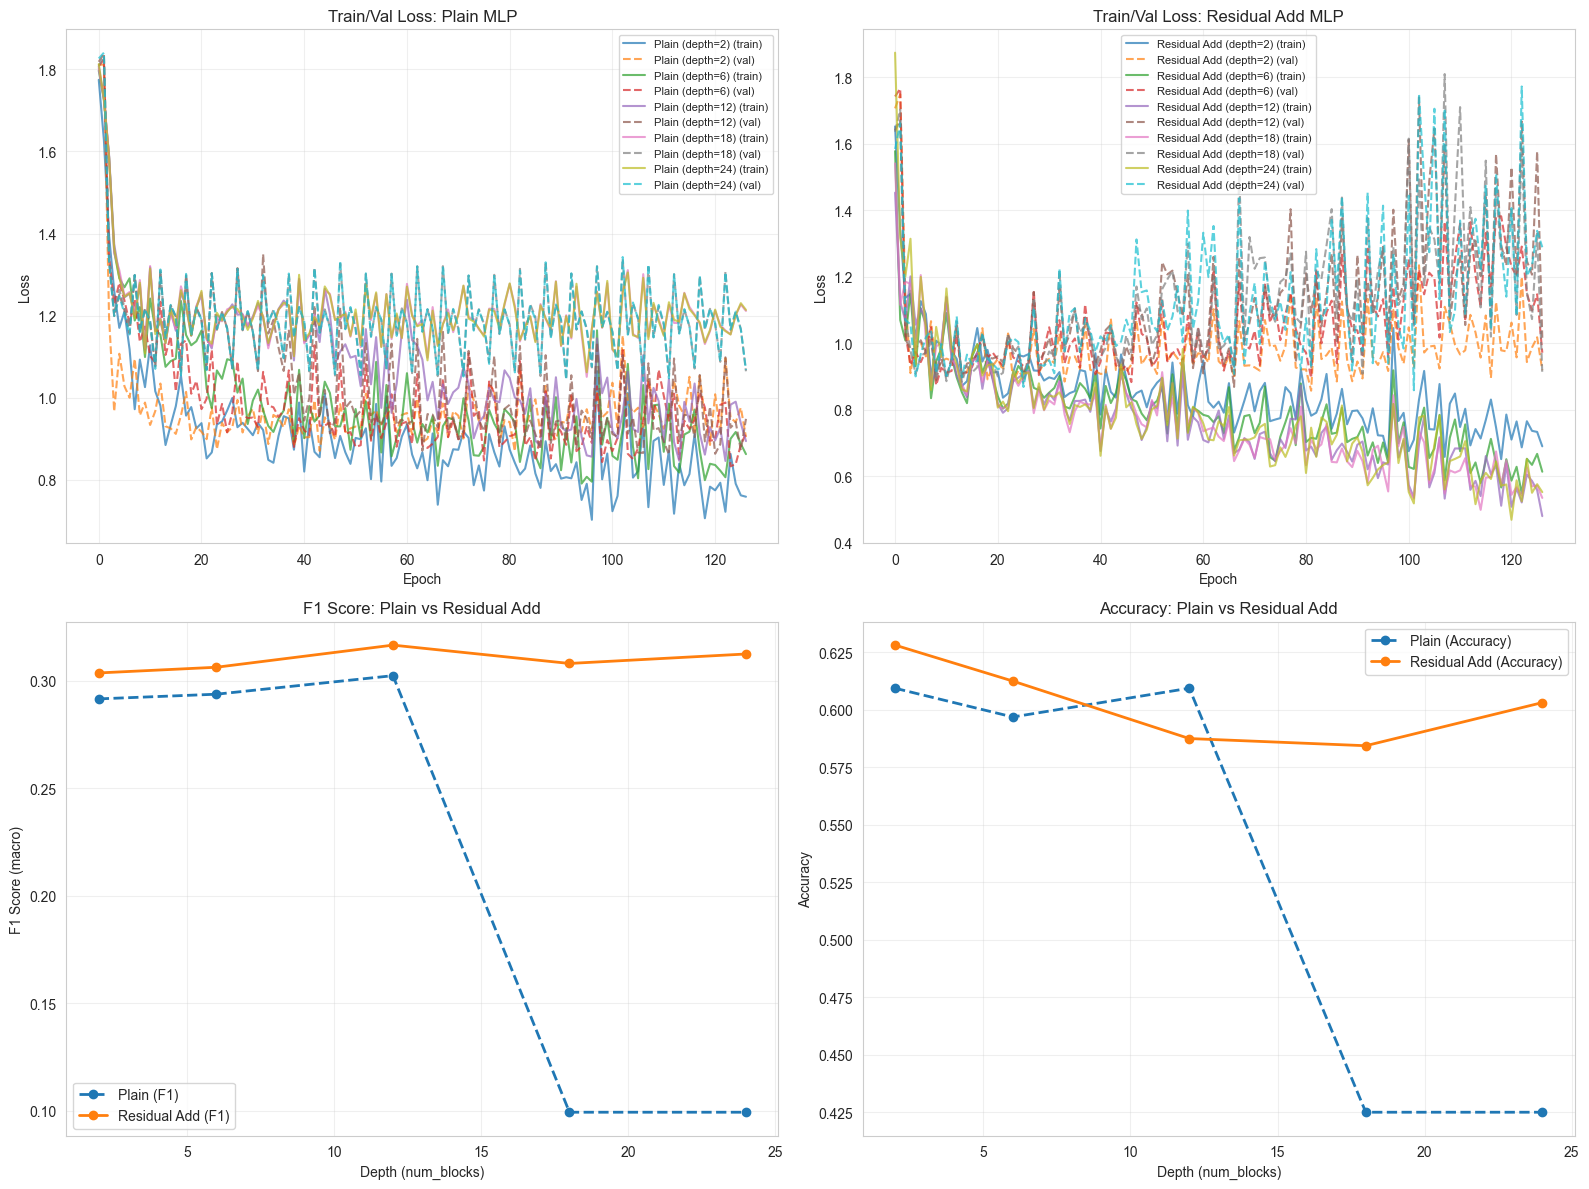

In [12]:
# Визуализация: Plain vs Residual Add
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График train/val loss
ax = axes[0, 0]
for name, history in results_plain_vs_add.items():
    num_epochs = len(history['val_loss'])
    train_loss_avg = average_train_loss_by_epochs(history['train_loss'], num_epochs)
    epochs = range(num_epochs)
    if 'Plain' in name:
        ax.plot(epochs, train_loss_avg, label=f"{name} (train)", linestyle='-', alpha=0.7)
        ax.plot(epochs, history['val_loss'], label=f"{name} (val)", linestyle='--', alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train/Val Loss: Plain MLP')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
for name, history in results_plain_vs_add.items():
    num_epochs = len(history['val_loss'])
    train_loss_avg = average_train_loss_by_epochs(history['train_loss'], num_epochs)
    epochs = range(num_epochs)
    if 'Residual Add' in name:
        ax.plot(epochs, train_loss_avg, label=f"{name} (train)", linestyle='-', alpha=0.7)
        ax.plot(epochs, history['val_loss'], label=f"{name} (val)", linestyle='--', alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train/Val Loss: Residual Add MLP')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Сравнение метрик по глубинам
ax = axes[1, 0]
plain_depths = sorted([int(n.split('depth=')[1].split(')')[0]) for n in results_plain_vs_add.keys() if 'Plain' in n])
add_depths = sorted([int(n.split('depth=')[1].split(')')[0]) for n in results_plain_vs_add.keys() if 'Residual Add' in n])

f1_plain = [results_plain_vs_add[f"Plain (depth={d})"]['final_f1'] for d in plain_depths]
f1_add = [results_plain_vs_add[f"Residual Add (depth={d})"]['final_f1'] for d in add_depths]

ax.plot(plain_depths, f1_plain, marker='o', label='Plain (F1)', linewidth=2, linestyle='--')
ax.plot(add_depths, f1_add, marker='o', label='Residual Add (F1)', linewidth=2)
ax.set_xlabel('Depth (num_blocks)')
ax.set_ylabel('F1 Score (macro)')
ax.set_title('F1 Score: Plain vs Residual Add')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
accuracy_plain = [results_plain_vs_add[f"Plain (depth={d})"]['final_accuracy'] for d in plain_depths]
accuracy_add = [results_plain_vs_add[f"Residual Add (depth={d})"]['final_accuracy'] for d in add_depths]

ax.plot(plain_depths, accuracy_plain, marker='o', label='Plain (Accuracy)', linewidth=2, linestyle='--')
ax.plot(add_depths, accuracy_add, marker='o', label='Residual Add (Accuracy)', linewidth=2)
ax.set_xlabel('Depth (num_blocks)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy: Plain vs Residual Add')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


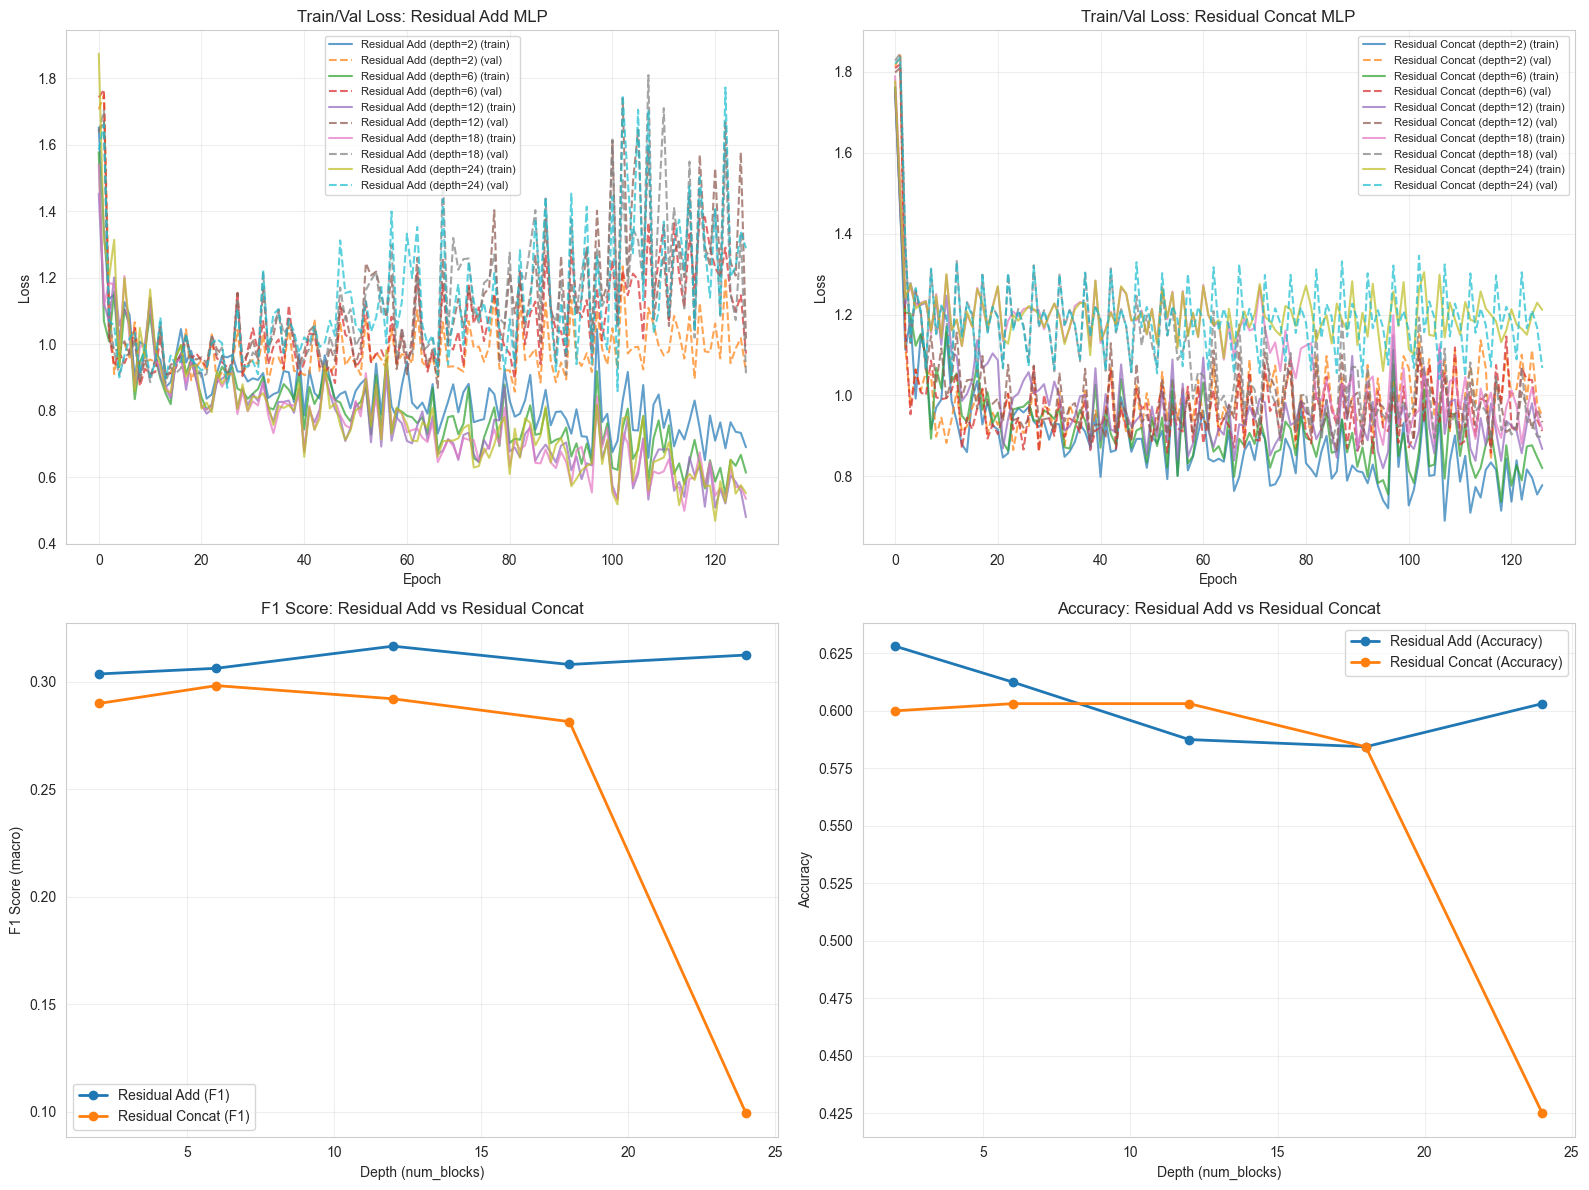

In [13]:
# Визуализация: Residual Add vs Residual Concat
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График train/val loss
ax = axes[0, 0]
for name, history in results_add_vs_concat.items():
    num_epochs = len(history['val_loss'])
    train_loss_avg = average_train_loss_by_epochs(history['train_loss'], num_epochs)
    epochs = range(num_epochs)
    if 'Residual Add' in name:
        ax.plot(epochs, train_loss_avg, label=f"{name} (train)", linestyle='-', alpha=0.7)
        ax.plot(epochs, history['val_loss'], label=f"{name} (val)", linestyle='--', alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train/Val Loss: Residual Add MLP')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
for name, history in results_add_vs_concat.items():
    num_epochs = len(history['val_loss'])
    train_loss_avg = average_train_loss_by_epochs(history['train_loss'], num_epochs)
    epochs = range(num_epochs)
    if 'Residual Concat' in name:
        ax.plot(epochs, train_loss_avg, label=f"{name} (train)", linestyle='-', alpha=0.7)
        ax.plot(epochs, history['val_loss'], label=f"{name} (val)", linestyle='--', alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train/Val Loss: Residual Concat MLP')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Сравнение метрик по глубинам
ax = axes[1, 0]
add_depths = sorted([int(n.split('depth=')[1].split(')')[0]) for n in results_add_vs_concat.keys() if 'Residual Add' in n])
concat_depths = sorted([int(n.split('depth=')[1].split(')')[0]) for n in results_add_vs_concat.keys() if 'Residual Concat' in n])

f1_add = [results_add_vs_concat[f"Residual Add (depth={d})"]['final_f1'] for d in add_depths]
f1_concat = [results_add_vs_concat[f"Residual Concat (depth={d})"]['final_f1'] for d in concat_depths]

ax.plot(add_depths, f1_add, marker='o', label='Residual Add (F1)', linewidth=2)
ax.plot(concat_depths, f1_concat, marker='o', label='Residual Concat (F1)', linewidth=2)
ax.set_xlabel('Depth (num_blocks)')
ax.set_ylabel('F1 Score (macro)')
ax.set_title('F1 Score: Residual Add vs Residual Concat')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
accuracy_add = [results_add_vs_concat[f"Residual Add (depth={d})"]['final_accuracy'] for d in add_depths]
accuracy_concat = [results_add_vs_concat[f"Residual Concat (depth={d})"]['final_accuracy'] for d in concat_depths]

ax.plot(add_depths, accuracy_add, marker='o', label='Residual Add (Accuracy)', linewidth=2)
ax.plot(concat_depths, accuracy_concat, marker='o', label='Residual Concat (Accuracy)', linewidth=2)
ax.set_xlabel('Depth (num_blocks)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy: Residual Add vs Residual Concat')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


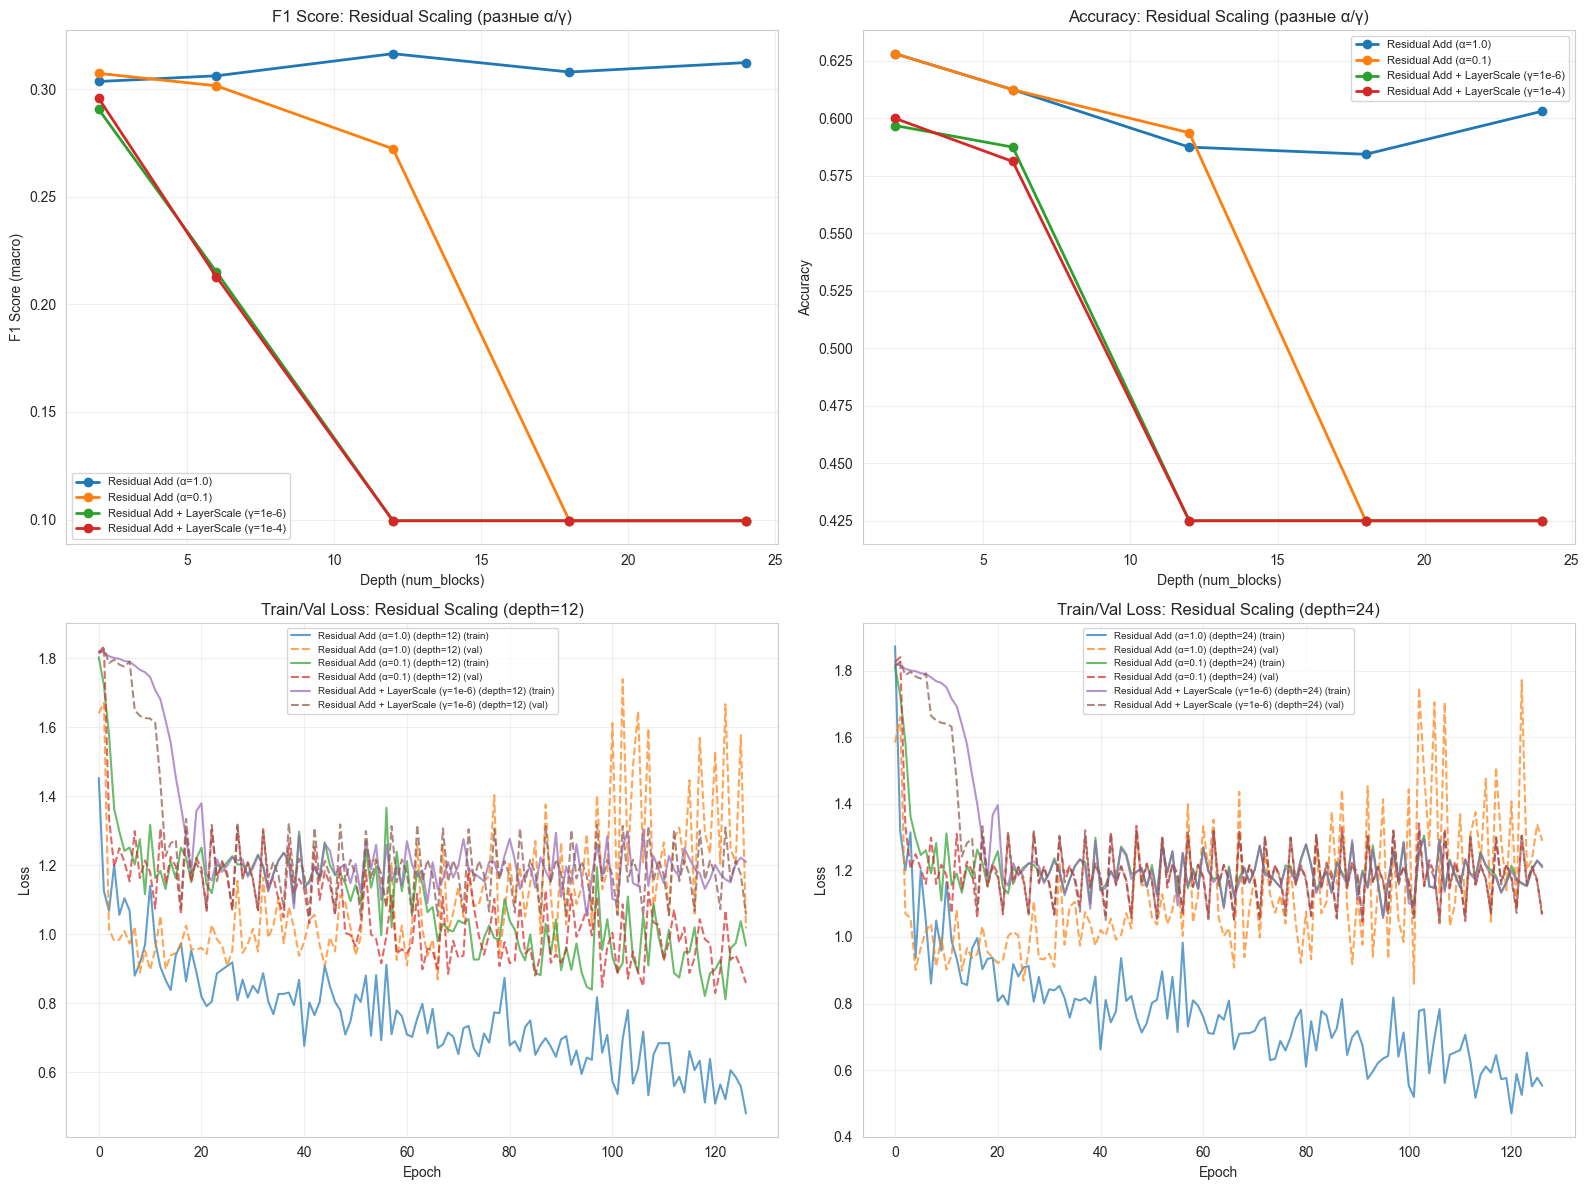


=== Выводы для Residual Scaling ===
Residual Add (α=1.0) - Лучший F1: Residual Add (α=1.0) (depth=12) (0.3165)
Residual Add (α=1.0) - Лучший Accuracy: Residual Add (α=1.0) (depth=2) (0.6281)
Residual Add (α=0.1) - Лучший F1: Residual Add (α=0.1) (depth=2) (0.3074)
Residual Add (α=0.1) - Лучший Accuracy: Residual Add (α=0.1) (depth=2) (0.6281)
Residual Add + LayerScale (γ=1e-6) - Лучший F1: Residual Add + LayerScale (γ=1e-6) (depth=2) (0.2906)
Residual Add + LayerScale (γ=1e-6) - Лучший Accuracy: Residual Add + LayerScale (γ=1e-6) (depth=2) (0.5969)
Residual Add + LayerScale (γ=1e-4) - Лучший F1: Residual Add + LayerScale (γ=1e-4) (depth=2) (0.2957)
Residual Add + LayerScale (γ=1e-4) - Лучший Accuracy: Residual Add + LayerScale (γ=1e-4) (depth=2) (0.6000)


In [14]:
# Визуализация: Residual Scaling
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Сравнение метрик по глубинам для разных конфигураций
ax = axes[0, 0]
for config_name in configs.keys():
    depths_list = sorted([int(n.split('depth=')[1].split(')')[0]) for n in results_scaling.keys() if config_name in n])
    f1_scores = [results_scaling[f"{config_name} (depth={d})"]['final_f1'] for d in depths_list]
    ax.plot(depths_list, f1_scores, marker='o', label=config_name, linewidth=2)
ax.set_xlabel('Depth (num_blocks)')
ax.set_ylabel('F1 Score (macro)')
ax.set_title('F1 Score: Residual Scaling (разные α/γ)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
for config_name in configs.keys():
    depths_list = sorted([int(n.split('depth=')[1].split(')')[0]) for n in results_scaling.keys() if config_name in n])
    accuracy_scores = [results_scaling[f"{config_name} (depth={d})"]['final_accuracy'] for d in depths_list]
    ax.plot(depths_list, accuracy_scores, marker='o', label=config_name, linewidth=2)
ax.set_xlabel('Depth (num_blocks)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy: Residual Scaling (разные α/γ)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# График train/val loss для лучших конфигураций
ax = axes[1, 0]
best_configs = ['Residual Add (α=1.0)', 'Residual Add (α=0.1)', 'Residual Add + LayerScale (γ=1e-6)']
for config_name in best_configs:
    for name, history in results_scaling.items():
        if config_name in name and 'depth=12' in name:
            num_epochs = len(history['val_loss'])
            train_loss_avg = average_train_loss_by_epochs(history['train_loss'], num_epochs)
            epochs = range(num_epochs)
            ax.plot(epochs, train_loss_avg, label=f"{name} (train)", linestyle='-', alpha=0.7)
            ax.plot(epochs, history['val_loss'], label=f"{name} (val)", linestyle='--', alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train/Val Loss: Residual Scaling (depth=12)')
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
for config_name in best_configs:
    for name, history in results_scaling.items():
        if config_name in name and 'depth=24' in name:
            num_epochs = len(history['val_loss'])
            train_loss_avg = average_train_loss_by_epochs(history['train_loss'], num_epochs)
            epochs = range(num_epochs)
            ax.plot(epochs, train_loss_avg, label=f"{name} (train)", linestyle='-', alpha=0.7)
            ax.plot(epochs, history['val_loss'], label=f"{name} (val)", linestyle='--', alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train/Val Loss: Residual Scaling (depth=24)')
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выводы
print("\n=== Выводы для Residual Scaling ===")
for config_name in configs.keys():
    names = [n for n in results_scaling.keys() if config_name in n]
    if names:
        best_f1 = max([(n, results_scaling[n]['final_f1']) for n in names], key=lambda x: x[1])
        best_accuracy = max([(n, results_scaling[n]['final_accuracy']) for n in names], key=lambda x: x[1])
        print(f"{config_name} - Лучший F1: {best_f1[0]} ({best_f1[1]:.4f})")
        print(f"{config_name} - Лучший Accuracy: {best_accuracy[0]} ({best_accuracy[1]:.4f})")
